# implement iterative identification of Ly$\alpha$ absorption

In [1]:
import os
import time
import pickle
import numpy as np

import torch
from torch import nn
from accelerate import Accelerator

import util as U
from spender import SpectrumAutoencoder
from spender.data import desi_qso as desi 

/home/chhahn/projects/spender_qso/bin/london/util.py:24: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _trapz_rebin(x, y, edges, results):


In [2]:
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
print("torch.cuda.device_count():",torch.cuda.device_count())

torch.cuda.device_count(): 1


In [4]:
niter = 0

In [5]:
def load_model(filename, models, instruments):
    device = instruments[0].wave_obs.device
    model_struct = torch.load(filename, map_location=device)
    #wave_rest = model_struct['model'][0]['decoder.wave_rest']
    
    for i, model in enumerate(models):
        # backwards compat: encoder.mlp instead of encoder.mlp.mlp
        if 'encoder.mlp.mlp.0.weight' in model_struct['model'][i].keys():
            from collections import OrderedDict
            model_struct['model'][i] = OrderedDict([(k.replace('mlp.mlp', 'mlp'), v) for k, v in model_struct['model'][i].items()])
        # backwards compat: add instrument to encoder
        try:
            model.load_state_dict(model_struct['model'][i], strict=False)
        except RuntimeError:
            model_struct['model'][i]['encoder.instrument.wave_obs']= instruments[i].wave_obs
            #model_struct['model'][i]['encoder.instrument.skyline_mask']= instruments[i].skyline_mask
            model.load_state_dict(model_struct[i]['model'], strict=False)

    losses = model_struct['losses']
    return models, losses

In [6]:
# define instruments
instruments = [ desi.DESI() ]

In [7]:
latents = 10 
z_min, z_max = 2.1, 3.5

# restframe wavelength for reconstructed spectra
# Note: represents joint dataset wavelength range
lmbda_min = instruments[0].wave_obs[0]/(1.0+z_max) # 2000 A
lmbda_max = instruments[0].wave_obs[-1]/(1.0+z_min) # 9824 A
bins = 9780
wave_rest = torch.linspace(lmbda_min, lmbda_max, bins, dtype=torch.float32)

# define and train the model
n_hidden = (64, 256, 1024)
models = [ SpectrumAutoencoder(instrument,
                               wave_rest,
                               n_latent=latents,
                               n_hidden=n_hidden,
                               act=[nn.LeakyReLU()]*(len(n_hidden)+1)
                               )
          for instrument in instruments ]

In [8]:
models, losses = load_model('/tigress/chhahn/spender_qso/models/qso.london.z_2p1_3p5.1sigma.iter%i.pt' % niter, models, instruments)

In [9]:
ibatch = 0 
with open('/tigress/chhahn/spender_qso/train/DESIlondon_highz.1sigma.iter%i_%i.pkl' % (niter, ibatch), "rb") as f:
    spec, w, z, target_id, norm, zerr = pickle.load(f)

In [11]:
with torch.no_grad():
    models[0].eval()
    instruments[0].eval()

    s = models[0].encode(spec)
    spec_rest = models[0].decode(s)

# 1. identify bad reconstructions 

In [10]:
def good_recon(wobs, fobs, iobs, wmod, fmod, zred, thresholds=[15, 0.1], verbose=False): 
    ''' determine whether a reconstruction is good or not
    '''
    wlim = wobs > 1300 * (1 + zred)
    try: 
        fmod_rebin = U.trapz_rebin(wmod, fmod, xnew=wobs)
        rchi2 = np.sum(((fobs - fmod_rebin)**2 * iobs)[wlim])/np.sum(wlim)
    except ValueError: 
        fmod_rebin = U.trapz_rebin(wmod, fmod, xnew=wobs[:-1])
        rchi2 = np.sum(((fobs[:-1] - fmod_rebin)**2 * iobs[:-1])[wlim[:-1]])/np.sum(wlim[:-1])
    
    w_coarse = np.linspace(1300 * (1 + zred), 9000, 100)
    
    fobs_rebin = U.trapz_rebin(wobs, fobs, xnew=w_coarse)
    fmod_rebin = U.trapz_rebin(wmod, fmod, xnew=w_coarse)
    metric = np.sum((fobs_rebin - fmod_rebin)**2)/float(len(w_coarse))
    
    if verbose: print('rchi2, metric', rchi2, metric)
    if (rchi2 < thresholds[0]) and (metric < thresholds[1]): 
        return True
    else: 
        return False

In [13]:
good_spender = [] 
for igal in range(spec.shape[0]):
    # check for reconstruction accuracy
    good_spender.append(good_recon(np.array(models[0].wave_obs), np.array(spec[igal]), np.array(w[igal]), 
                                   np.array(models[0].wave_rest * (1 + z[igal])), np.array(spec_rest[igal]),   
                                   z[igal].item(), thresholds=[10, 0.1], verbose=False))
good_spender = np.array(good_spender)

In [14]:
np.sum(~good_spender)

44

/home/chhahn/projects/spender_qso/bin/london/util.py:23: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_trapz_rebin" failed type inference due to: non-precise type pyobject
During: typing of argument at /home/chhahn/projects/spender_qso/bin/london/util.py (23)

File "util.py", line 23:
def centers2edges(centers):
    <source elided>

@numba.jit
^

  @numba.jit
/home/chhahn/projects/spender_qso/bin/london/util.py:23: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "_trapz_rebin" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "util.py", line 69:
def _trapz_rebin(x, y, edges, results):
    <source elided>

    for i in range(nbin):
    ^

  @numba.jit
/home/chhahn/.conda/envs/gqp/lib/python3.8/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "_trapz_rebin" was compiled in object mode without f

3
rchi2, metric 0.7047783211677892 0.18262619305420674
8
rchi2, metric 0.6274107938670926 0.1395291546552987
9
rchi2, metric 0.6354462257101812 0.15350097648985758
55
rchi2, metric 0.6697161274898883 0.11947238153518311
67
rchi2, metric 0.7341835561132455 0.1567917969583067


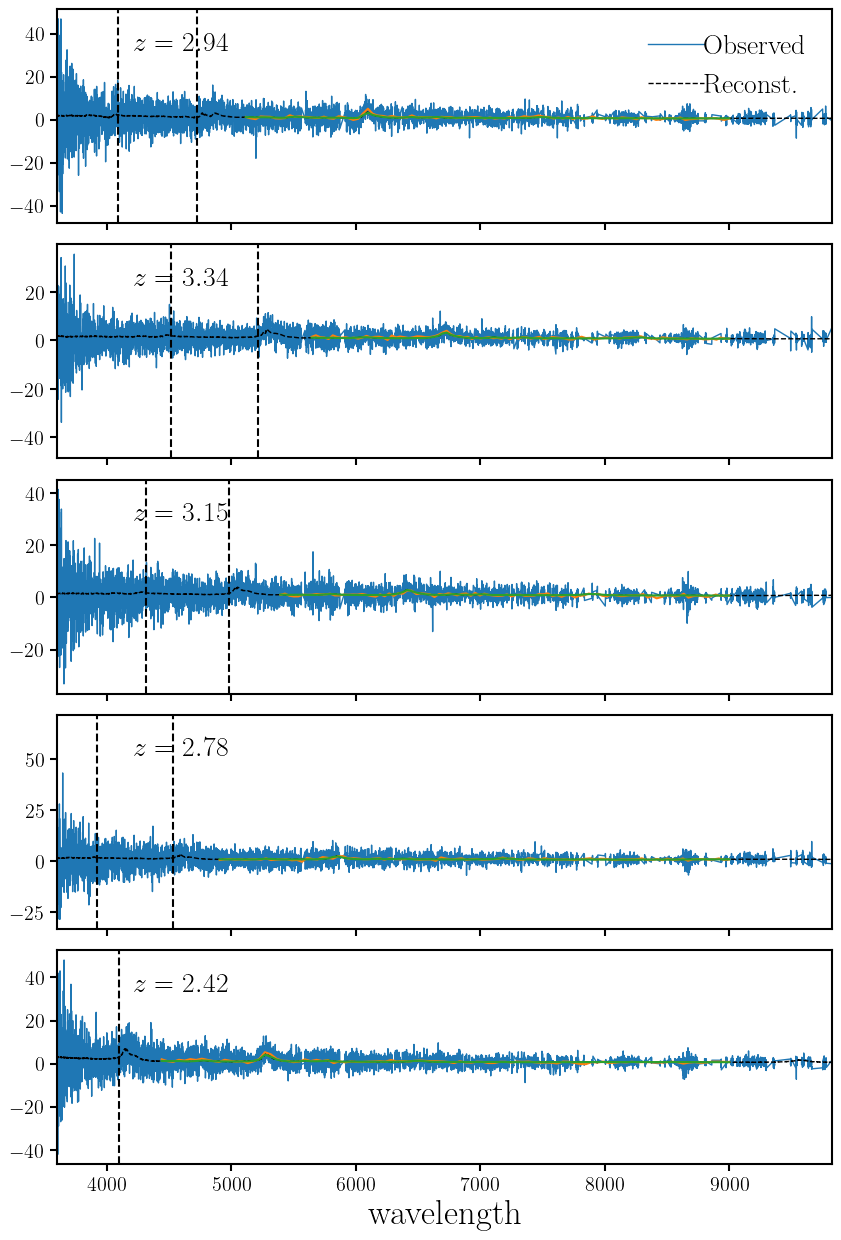

In [15]:
fig = plt.figure(figsize=(10,15))
for ii, igal in enumerate(np.arange(len(spec))[~good_spender][:5]):
    sub = fig.add_subplot(5,1,ii+1)
    sub.plot(models[0].wave_obs[w[igal] > 0], spec[igal][w[igal] > 0], lw=1, label='Observed')    
    sub.plot(models[0].wave_rest * (1 + z[igal]), spec_rest[igal], color='k', lw=1, ls='--', label='Reconst.')
    
    w_coarse = np.linspace(1300 * (1 + z[igal]), 9000, 100)
    
    fobs_coarse = U.trapz_rebin(models[0].wave_obs, spec[igal], xnew=w_coarse)
    sub.plot(w_coarse, fobs_coarse)
    fmod_coarse = U.trapz_rebin(models[0].wave_rest * (1 + z[igal]), spec_rest[igal], xnew=w_coarse)
    sub.plot(w_coarse, fmod_coarse)

    
    # check for reconstruction accuracy
    print(igal)
    good_recon(np.array(models[0].wave_obs), np.array(spec[igal]), np.array(w[igal]), 
                                   np.array(models[0].wave_rest * (1 + z[igal])), np.array(spec_rest[igal]),   
                                   z[igal].item(), thresholds=[15, 0.1], verbose=True)
    
    sub.axvline(1040. * (1+z[igal]), linestyle='--', color='k')
    sub.axvline(1200. * (1+z[igal]), linestyle='--', color='k')

    sub.text(0.1, 0.9, '$z=%.2f$' % z[igal], ha='left', va='top', fontsize=20, transform=sub.transAxes)

    sub.set_xlim(models[0].wave_obs[0], models[0].wave_obs[-1])
    if ii < 4: sub.set_xticklabels([])
    if ii == 0: sub.legend(loc='upper right', fontsize=20, handletextpad=0)
sub.set_xlabel("wavelength", fontsize=25)
fig.subplots_adjust(hspace=0.1)
plt.show()

In [11]:
def find_absorption_aggro(wobs, fobs, iobs, zobs, wmod, fmod, verbose=False): 
    ''' find absorption
    '''
    w_lya = 1215.67 * (1. + zobs) # wavelenght of LyA    
    try:
        # rebin flux to observed wavelength 
        fmod_rebin = U.trapz_rebin(wmod, fmod, xnew=wobs)
            
        is_absorb = np.zeros(len(wobs)).astype(bool)
        below_lya = (wobs < w_lya)
        is_absorb[below_lya] = (fmod_rebin - fobs)[below_lya] > iobs[below_lya]**-0.5 # super aggressive 1sigma clipping
        is_absorb[~below_lya] = (fmod_rebin - fobs)[~below_lya] > 3*iobs[~below_lya]**-0.5
    
    except ValueError: 
        fmod_rebin = U.trapz_rebin(wmod, fmod, xnew=wobs[:-1])
        
        is_absorb = np.zeros(len(wobs)).astype(bool)
        is_absorb[:-1] = (fmod_rebin - fobs[:-1]) > 3*iobs[:-1]**-0.5
        below_lya = (wobs[:-1] < w_lya)
        is_absorb[:-1][below_lya] = (fmod_rebin - fobs[:-1])[below_lya] > iobs[:-1][below_lya]**-0.5 # super aggressive 1sigma clipping        
        
    return is_absorb

<ipython-input-16-4779e8f7f0e3>:11: RuntimeWarning: divide by zero encountered in power
  is_absorb[below_lya] = (fmod_rebin - fobs)[below_lya] > iobs[below_lya]**-0.5 # super aggressive 1sigma clipping
<ipython-input-16-4779e8f7f0e3>:12: RuntimeWarning: divide by zero encountered in power
  is_absorb[~below_lya] = (fmod_rebin - fobs)[~below_lya] > 3*iobs[~below_lya]**-0.5


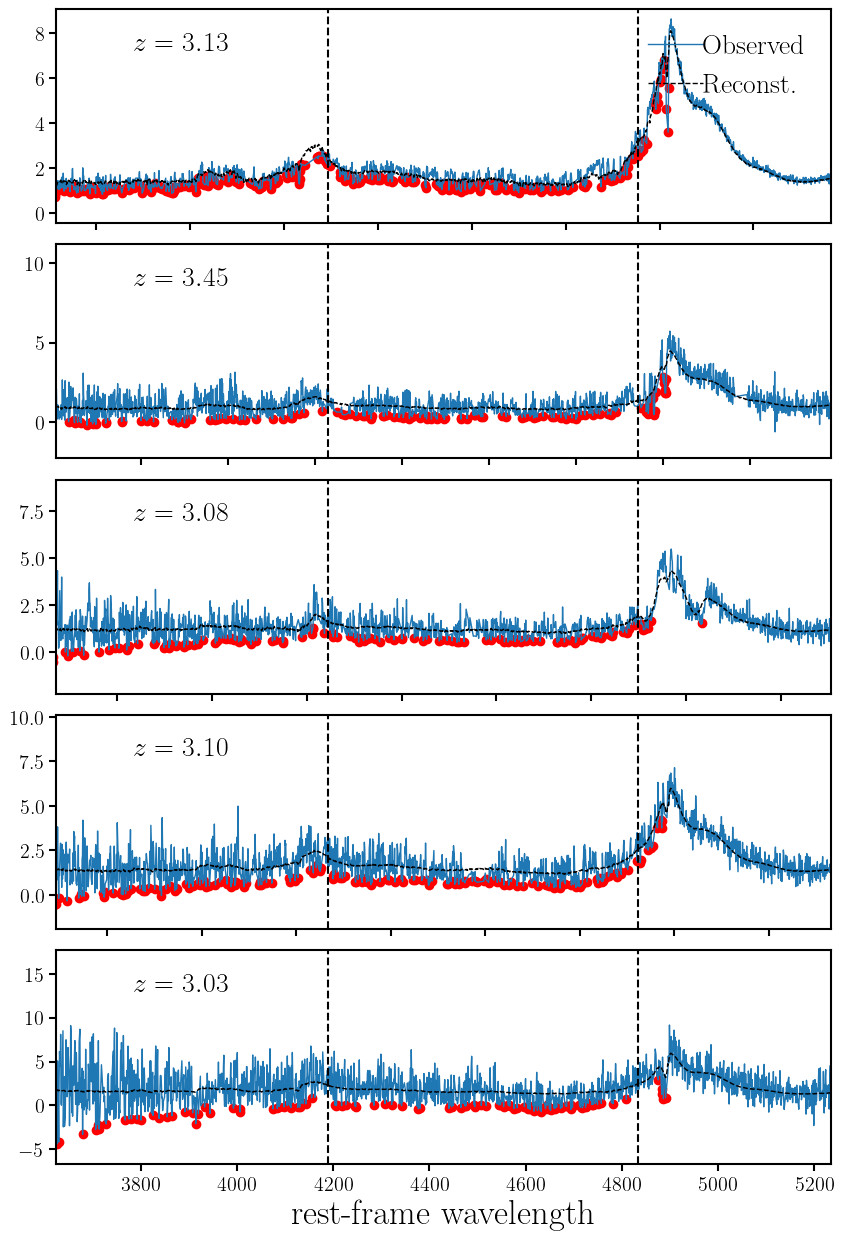

In [17]:
fig = plt.figure(figsize=(10,15))
for ii, igal in enumerate(np.random.choice(np.arange(len(spec))[good_spender & (np.array(z) > 3)], size=5, replace=False)): 
    sub = fig.add_subplot(5,1,ii+1)
    sub.plot(models[0].wave_obs[w[igal] > 0], spec[igal][w[igal] > 0], lw=1, label='Observed')    
    sub.plot(models[0].wave_rest * (1 + z[igal]), spec_rest[igal], color='k', lw=1, ls='--', label='Reconst.')
        
    is_absorb = find_absorption_aggro(np.array(models[0].wave_obs), np.array(spec[igal]), np.array(w[igal]), np.array(z[igal]), 
                                      np.array(models[0].wave_rest * (1 + z[igal])), np.array(spec_rest[igal]))
    sub.scatter(models[0].wave_obs[is_absorb], spec[igal][is_absorb], c='r')
    
    sub.axvline(1040. * (1+z[igal]), linestyle='--', color='k')
    sub.axvline(1200. * (1+z[igal]), linestyle='--', color='k')

    sub.text(0.1, 0.9, '$z=%.2f$' % z[igal], ha='left', va='top', fontsize=20, transform=sub.transAxes)

    sub.set_xlim(900 * (1+z[igal]), 1300. * (1+z[igal]))
    if ii < 4: sub.set_xticklabels([])
    if ii == 0: sub.legend(loc='upper right', fontsize=20, handletextpad=0)
sub.set_xlabel("rest-frame wavelength", fontsize=25)
fig.subplots_adjust(hspace=0.1)
plt.show()

# 3. deploy on batches

BATCH 0
44
tensor(1.3836e+08)


<ipython-input-11-4779e8f7f0e3>:11: RuntimeWarning: divide by zero encountered in power
  is_absorb[below_lya] = (fmod_rebin - fobs)[below_lya] > iobs[below_lya]**-0.5 # super aggressive 1sigma clipping
<ipython-input-11-4779e8f7f0e3>:12: RuntimeWarning: divide by zero encountered in power
  is_absorb[~below_lya] = (fmod_rebin - fobs)[~below_lya] > 3*iobs[~below_lya]**-0.5
<ipython-input-12-a3c5c130c5ea>:44: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  sub.plot(models[0].wave_obs[(w[igal] > 0) & ~is_absorb], spec[igal][(w[igal] > 0) & ~is_absorb], c='k', alpha=0.5, lw=1, label='Observed')


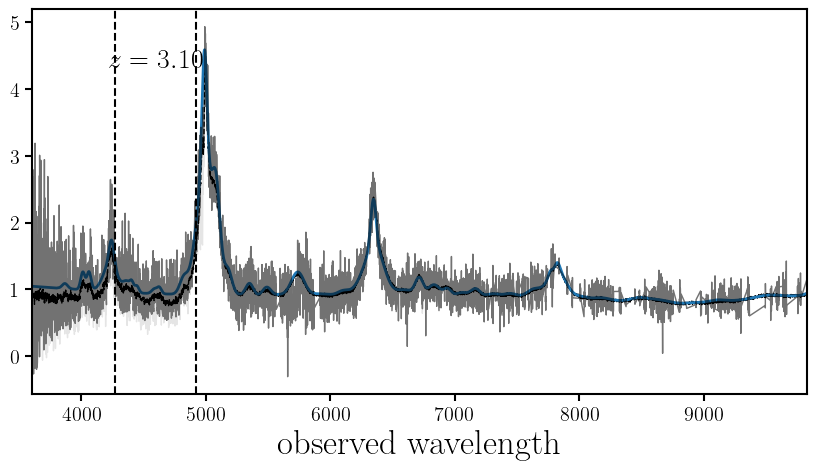

<ipython-input-11-4779e8f7f0e3>:11: RuntimeWarning: divide by zero encountered in power
  is_absorb[below_lya] = (fmod_rebin - fobs)[below_lya] > iobs[below_lya]**-0.5 # super aggressive 1sigma clipping
<ipython-input-11-4779e8f7f0e3>:12: RuntimeWarning: divide by zero encountered in power
  is_absorb[~below_lya] = (fmod_rebin - fobs)[~below_lya] > 3*iobs[~below_lya]**-0.5
<ipython-input-12-a3c5c130c5ea>:44: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  sub.plot(models[0].wave_obs[(w[igal] > 0) & ~is_absorb], spec[igal][(w[igal] > 0) & ~is_absorb], c='k', alpha=0.5, lw=1, label='Observed')


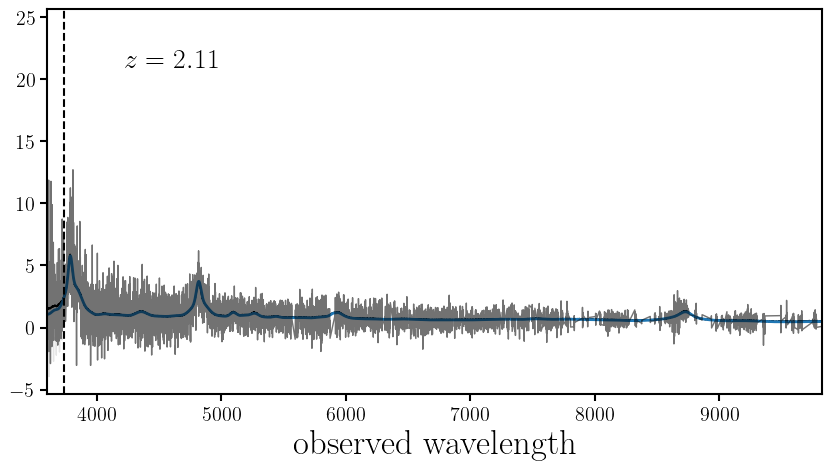

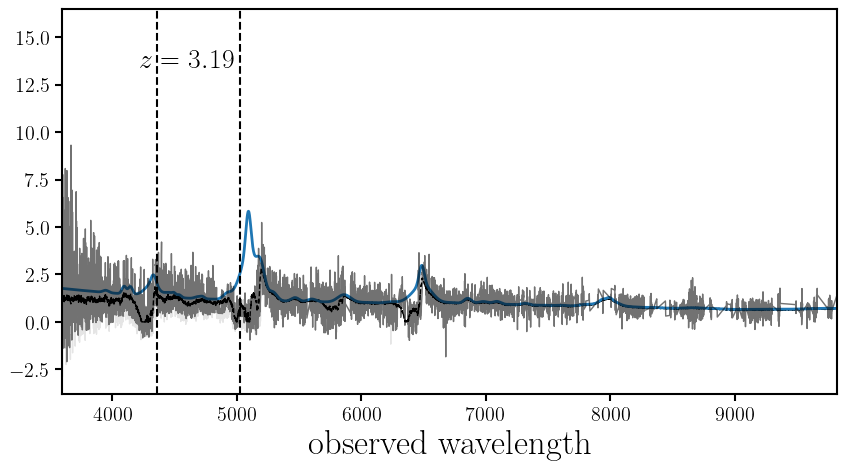

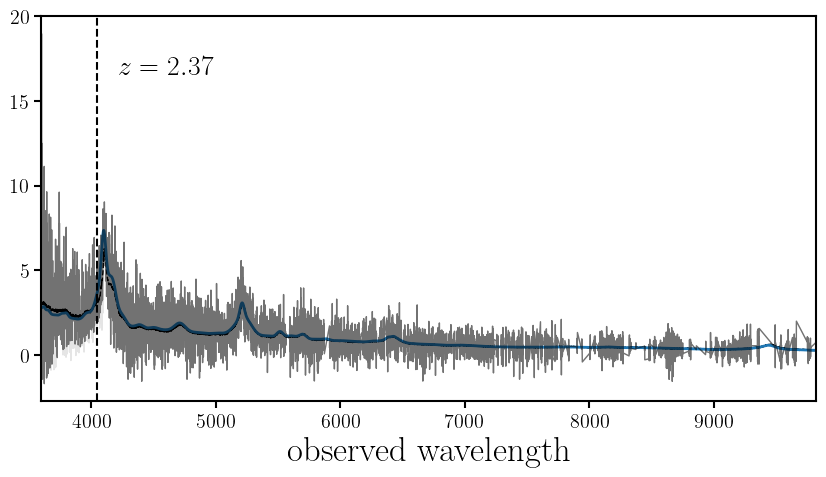

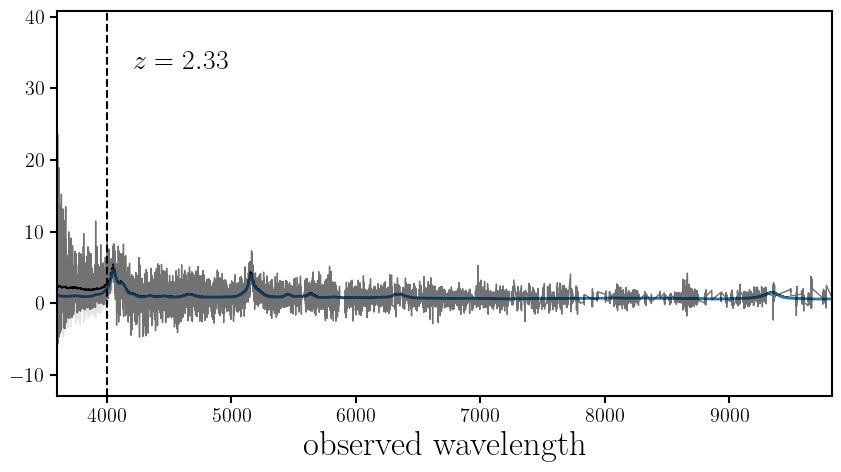

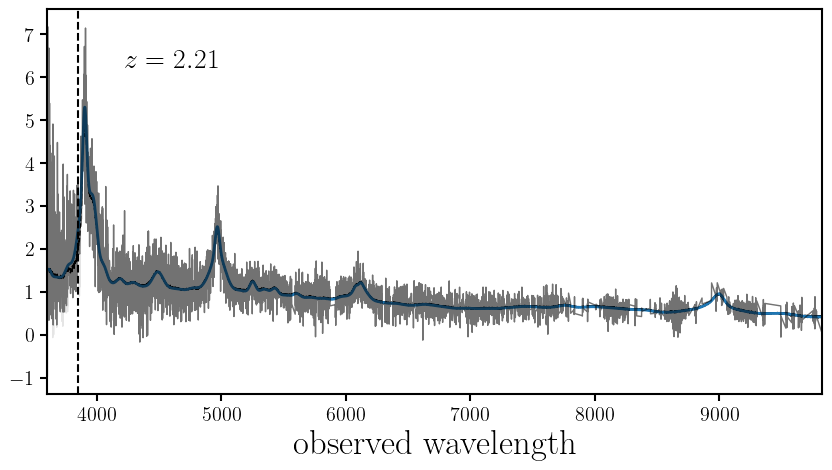

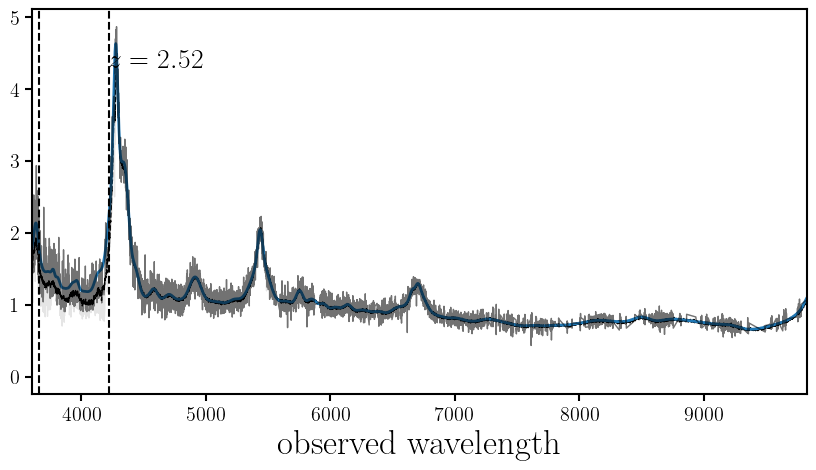

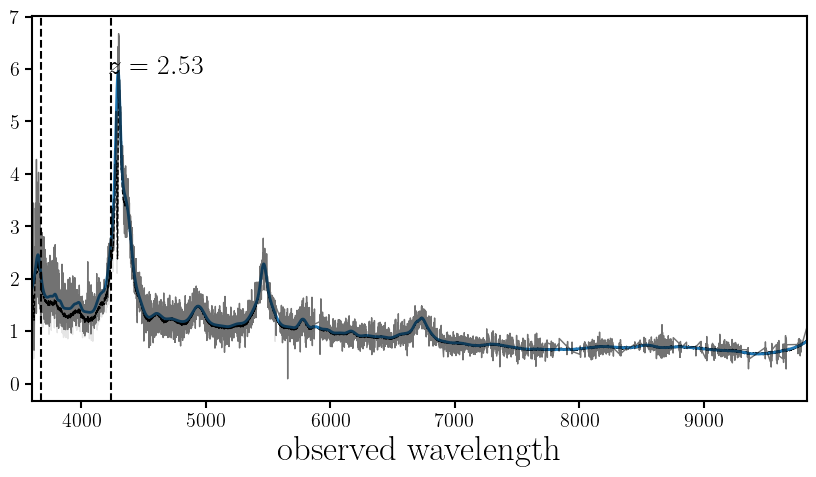

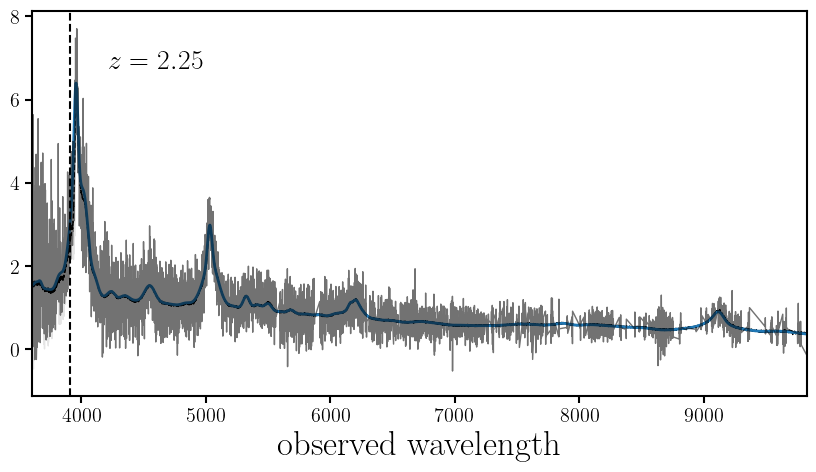

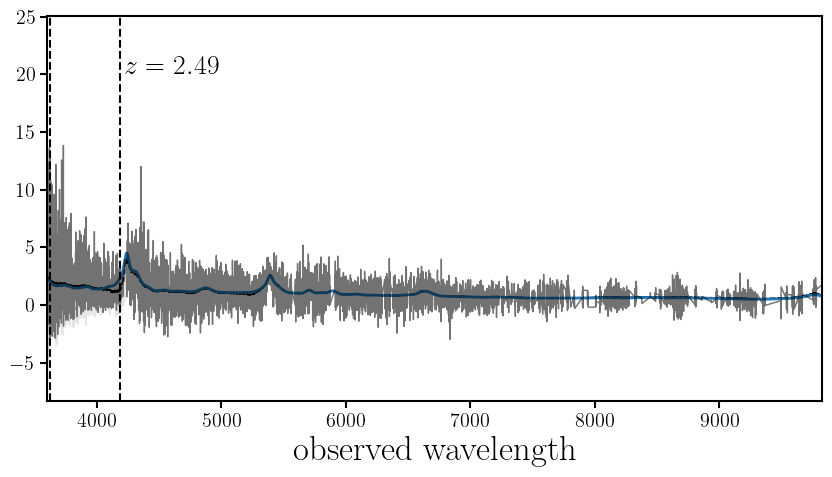

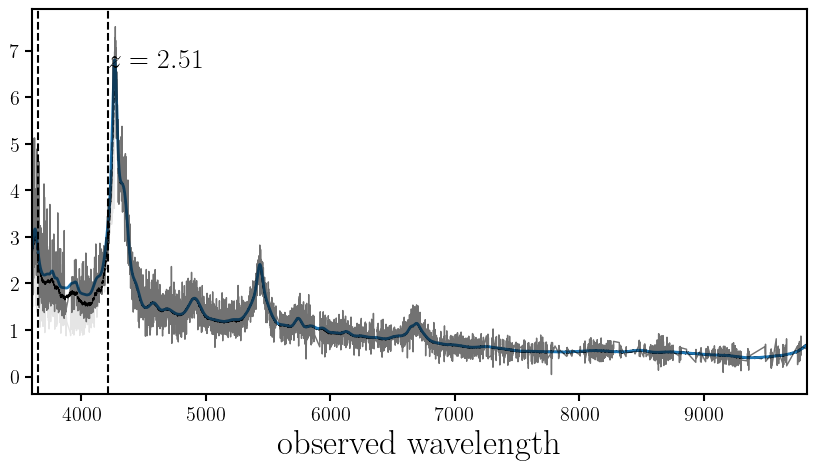

tensor(1.3836e+08)
BATCH 1
45
tensor(2.0704e+08)


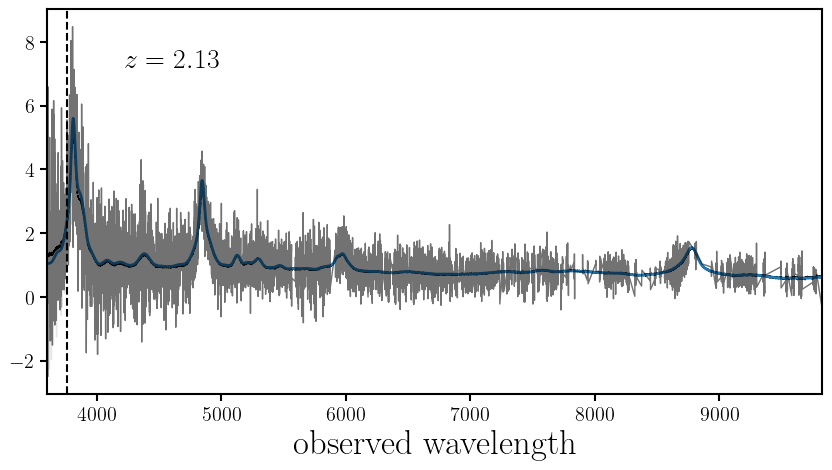

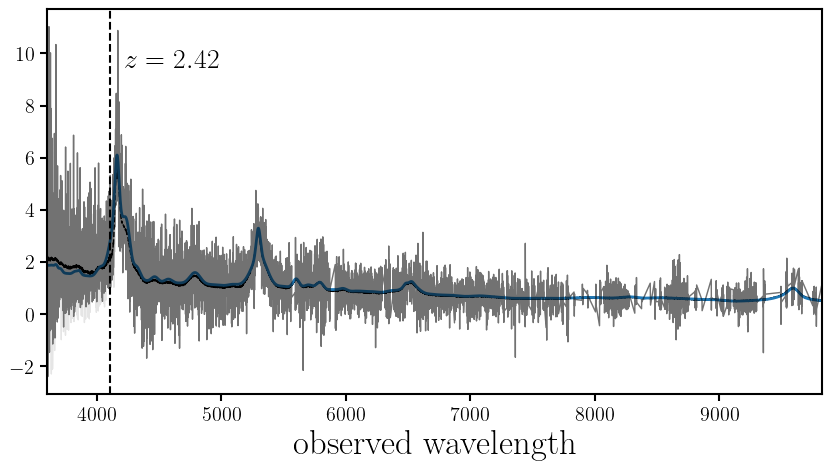

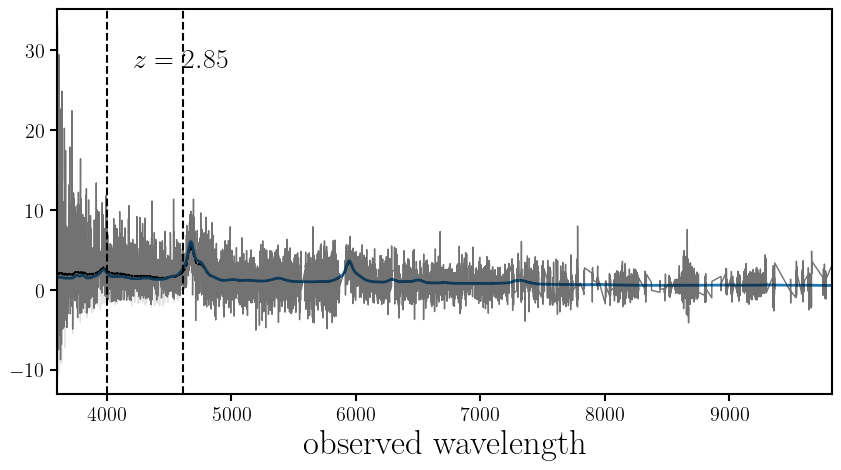

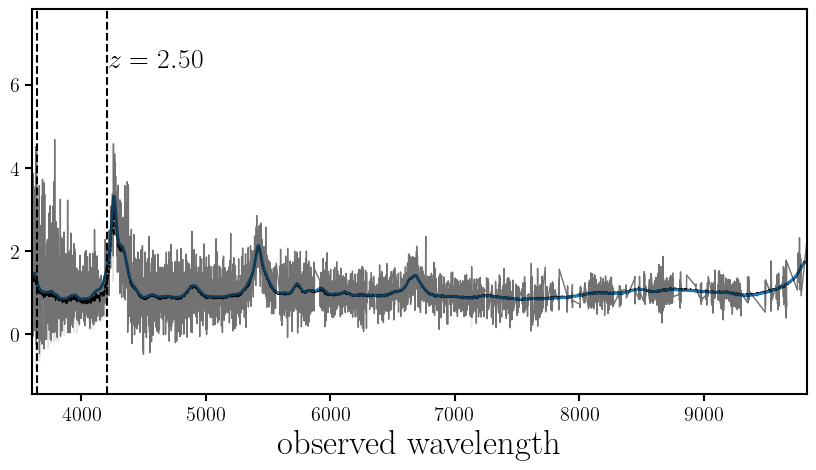

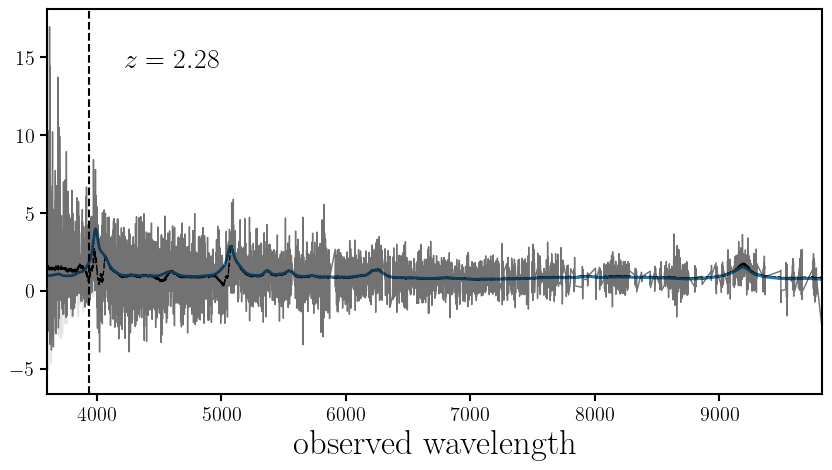

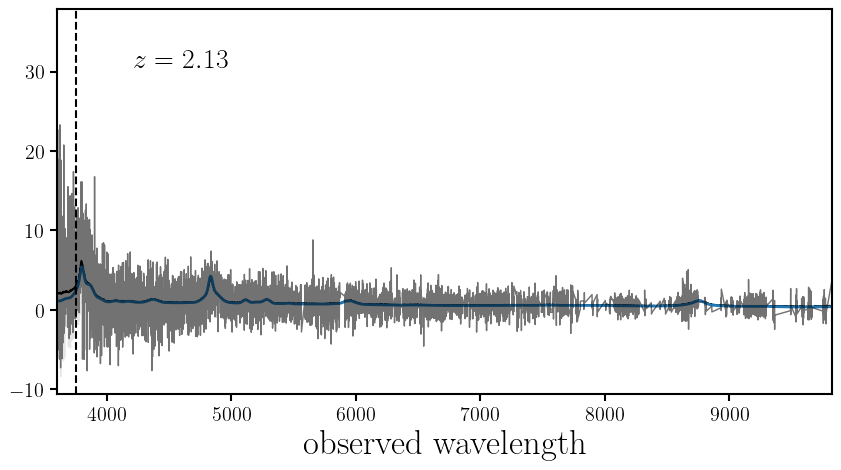

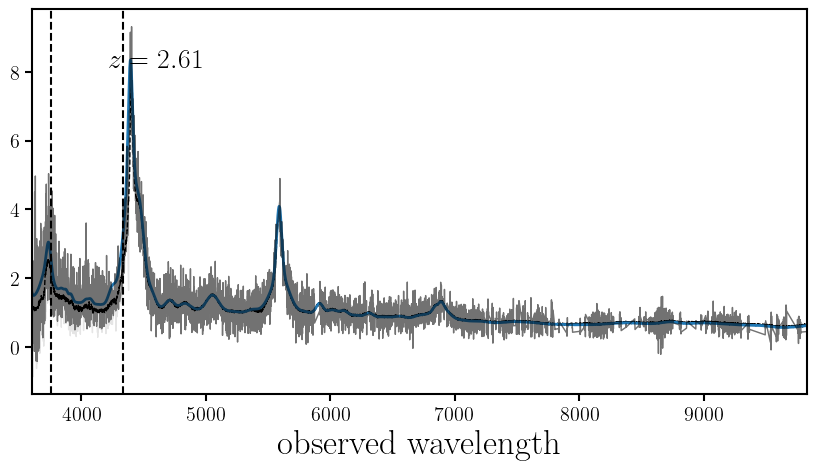

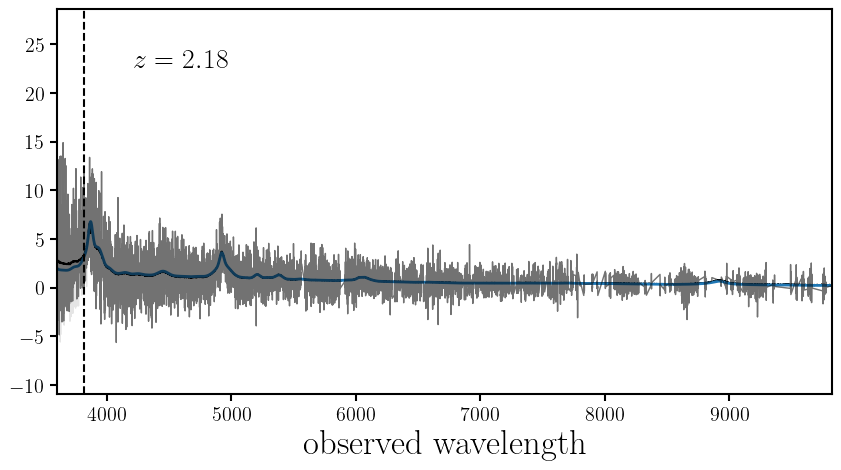

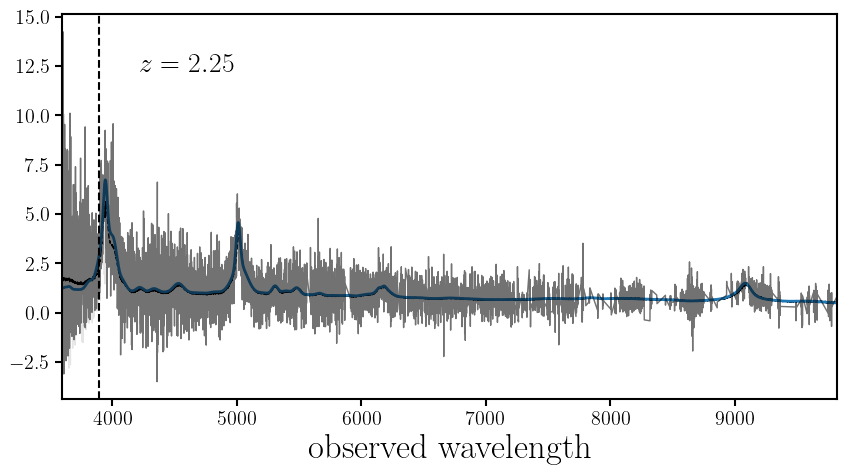

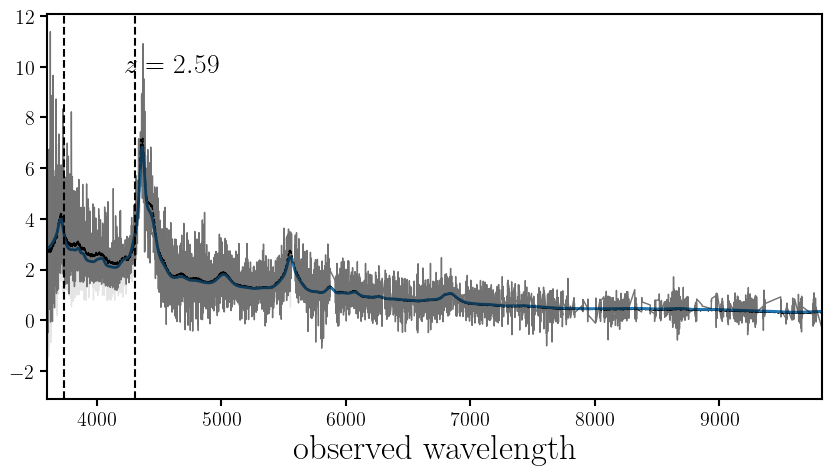

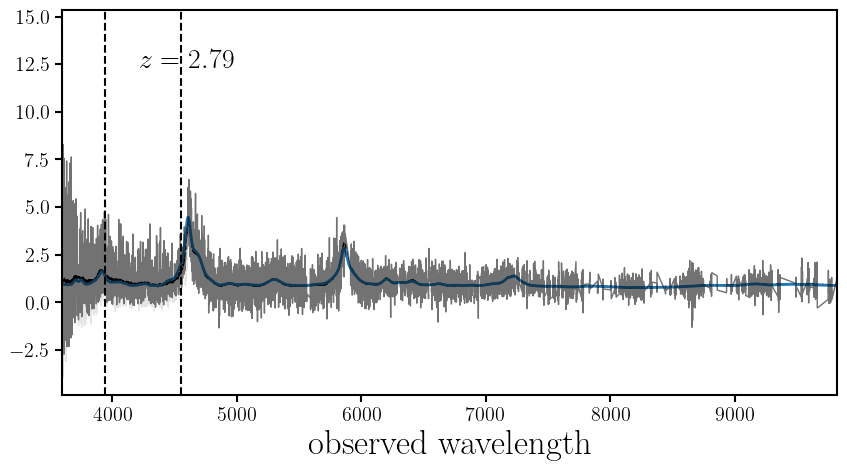

tensor(2.0704e+08)
BATCH 2
25
tensor(2.4854e+08)


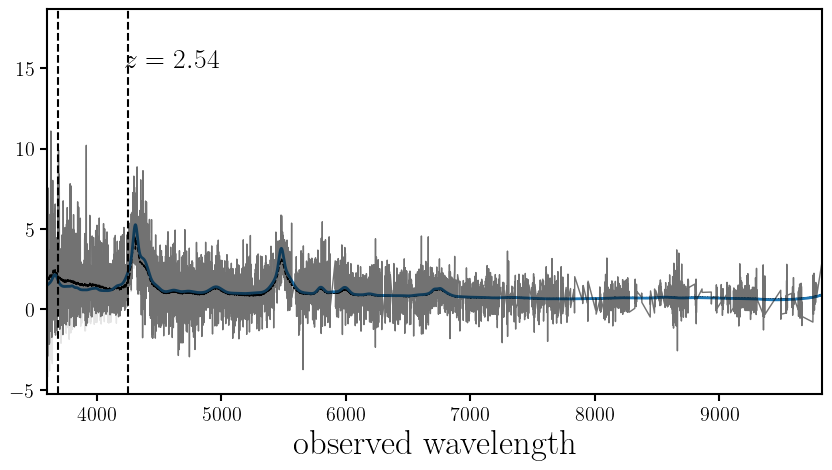

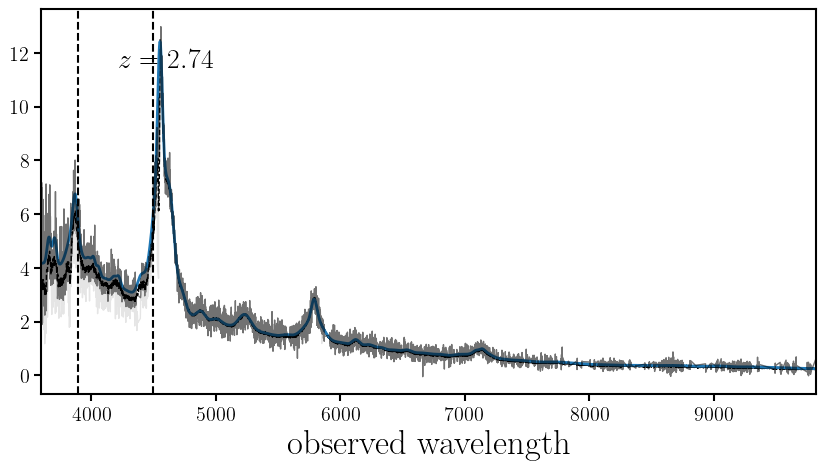

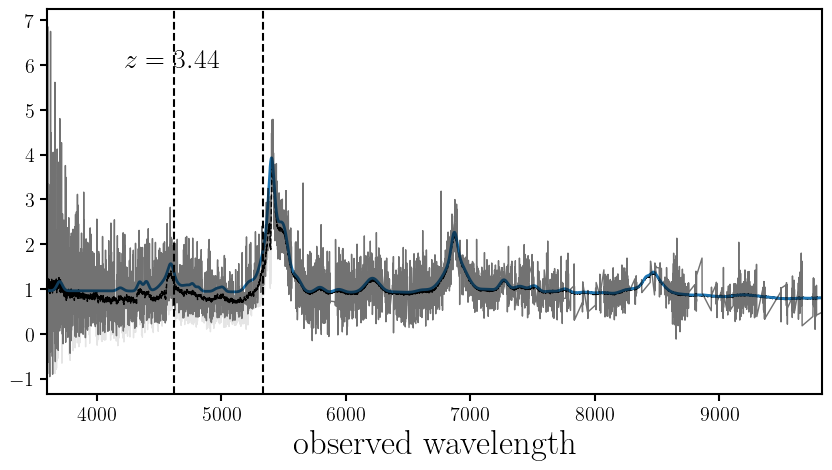

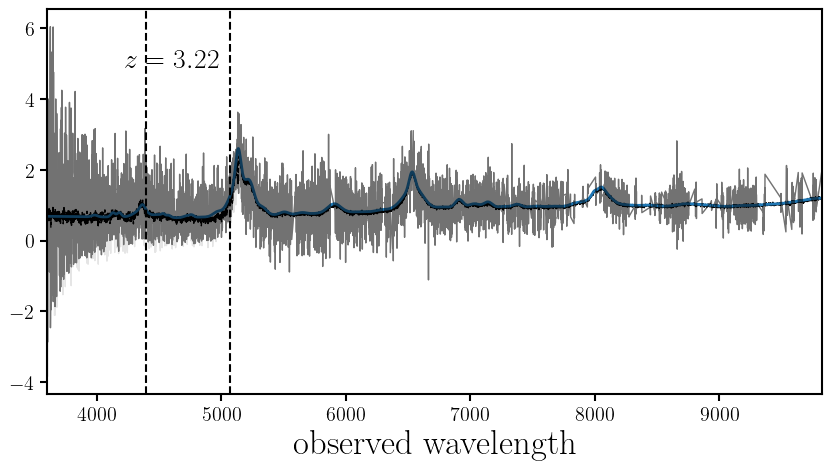

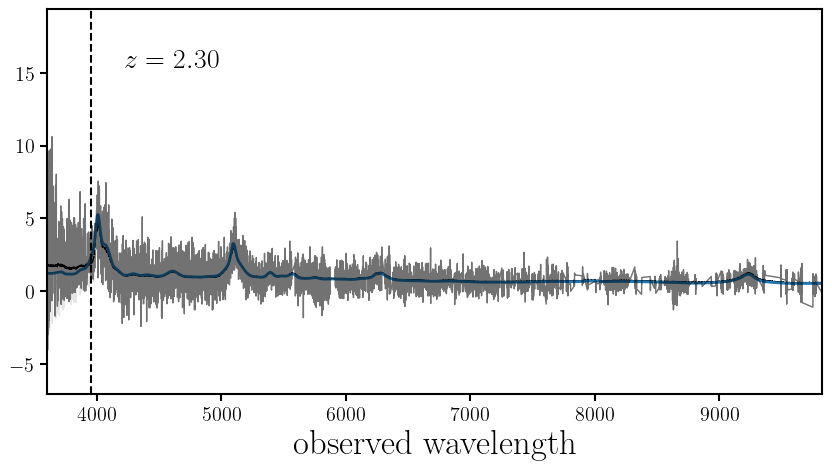

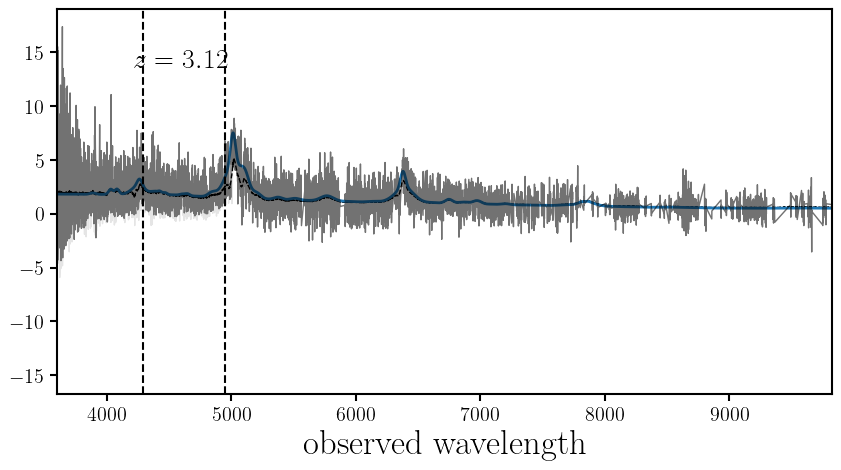

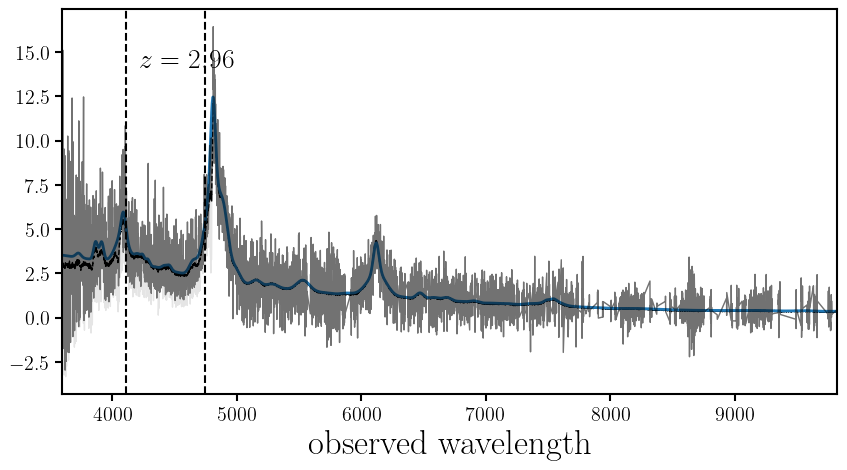

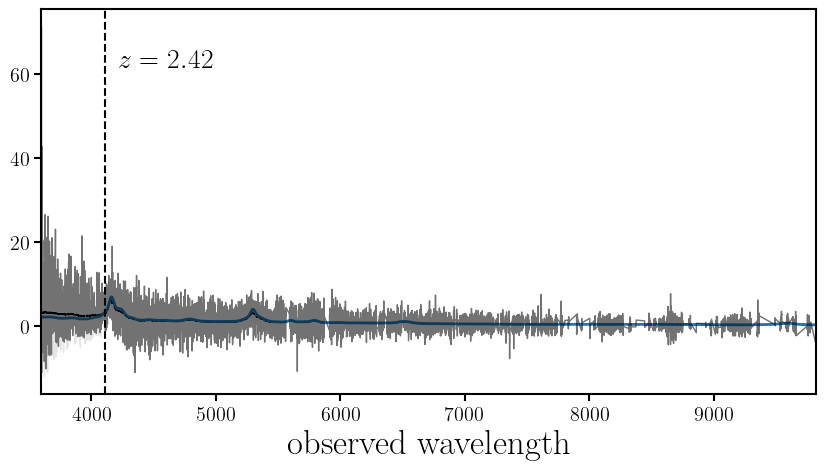

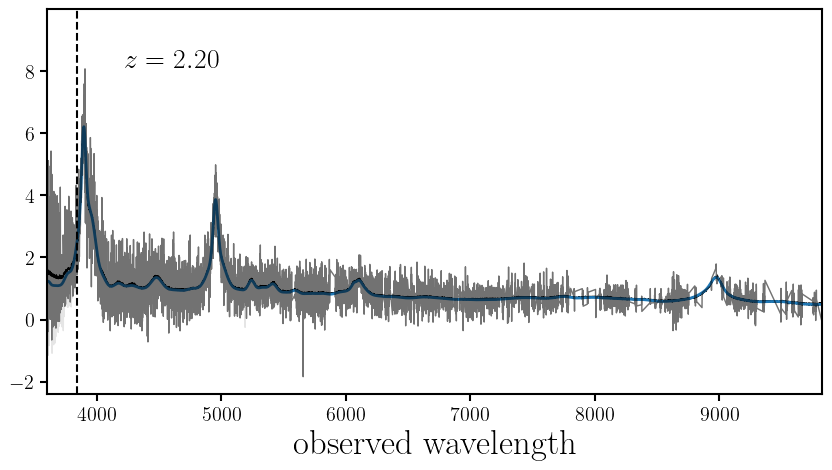

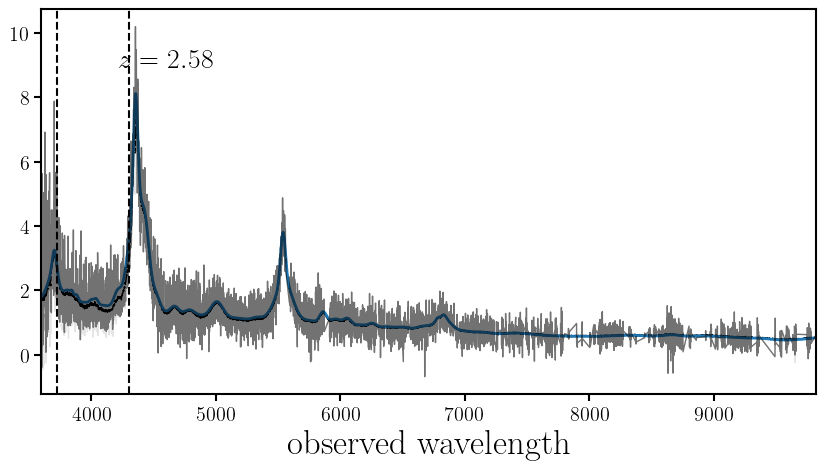

tensor(2.4854e+08)
BATCH 3
28
tensor(1.6953e+08)


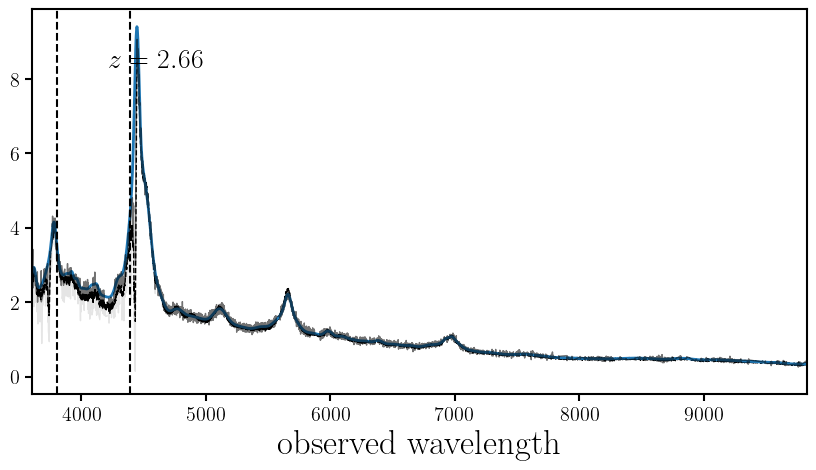

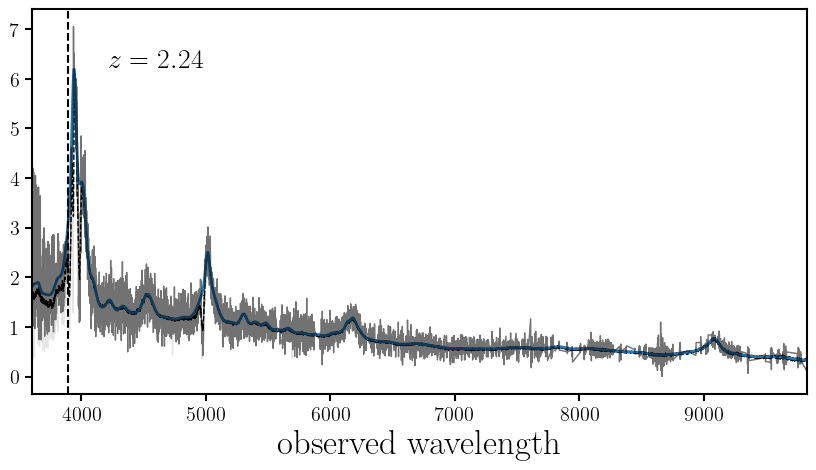

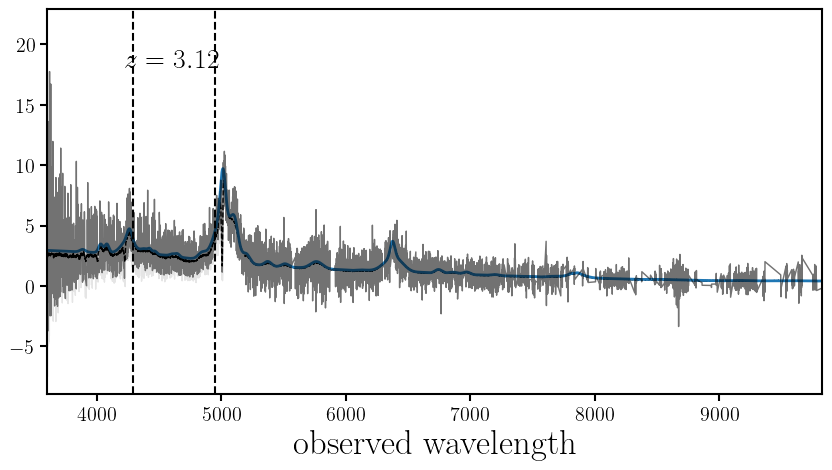

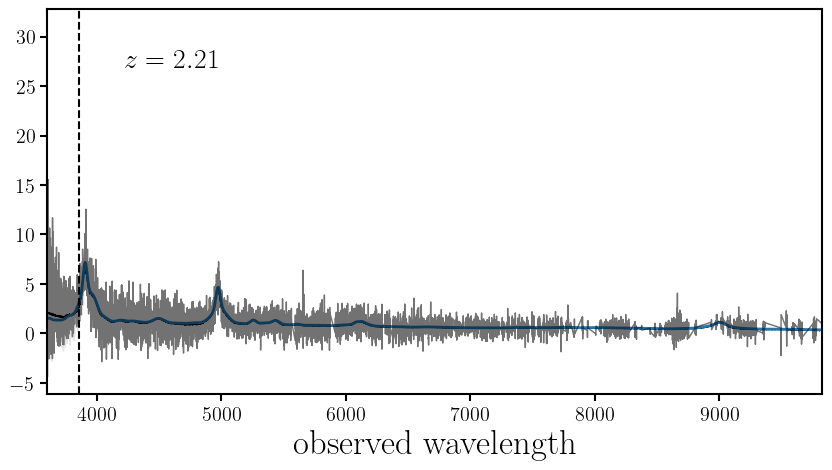

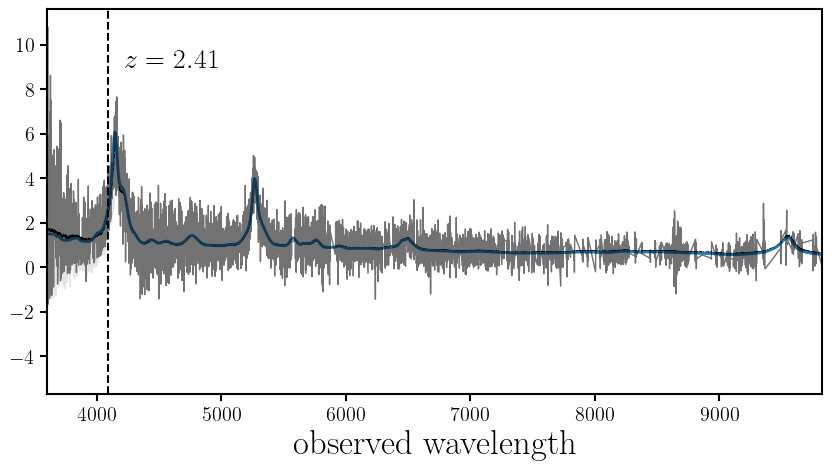

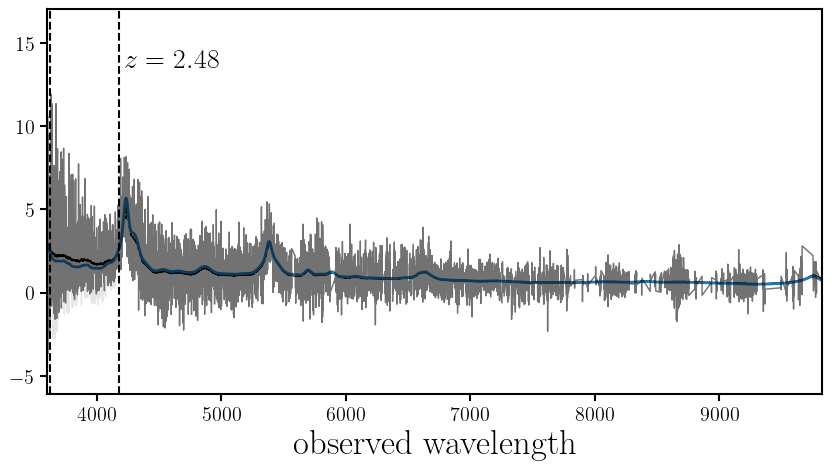

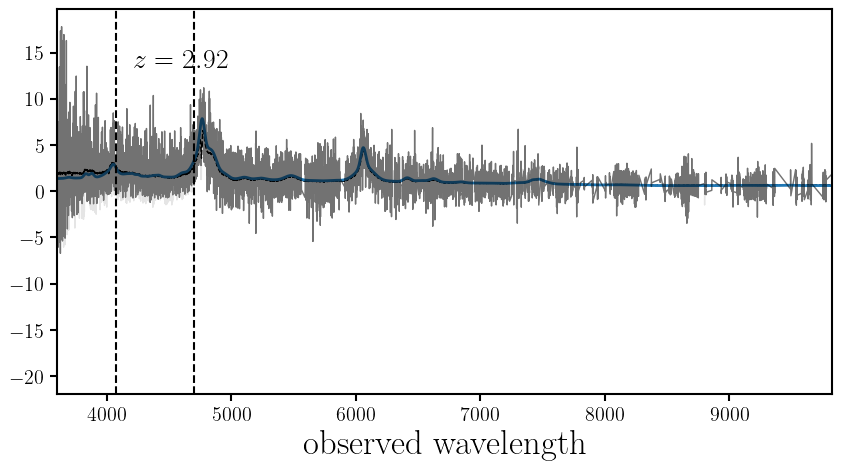

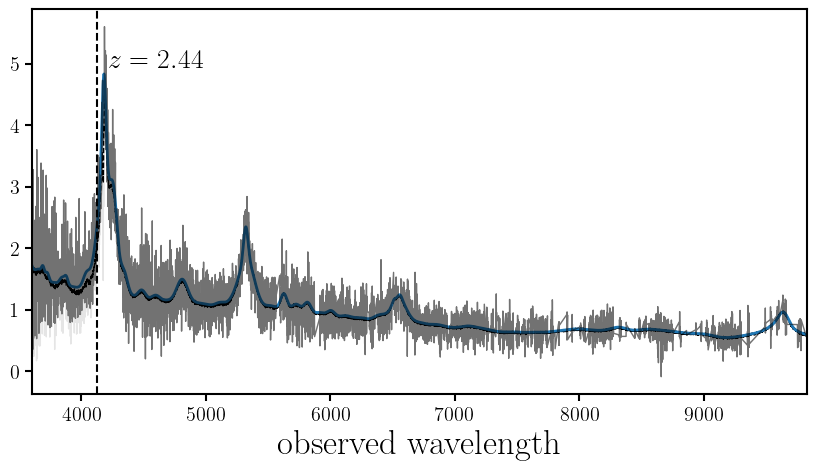

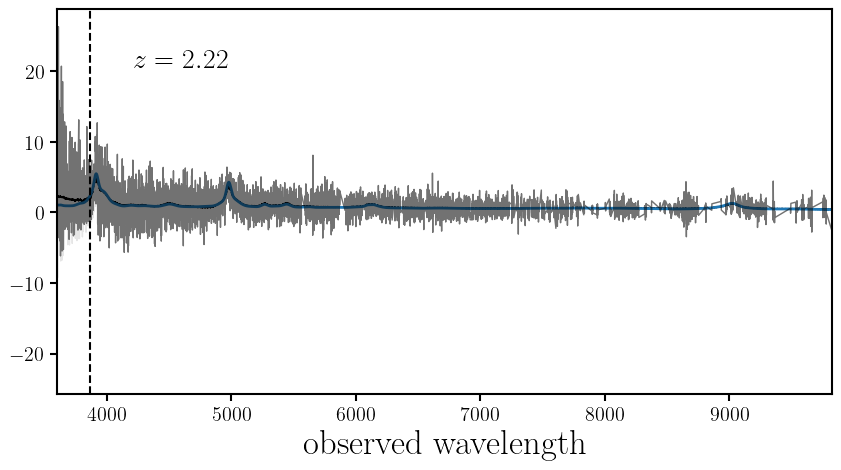

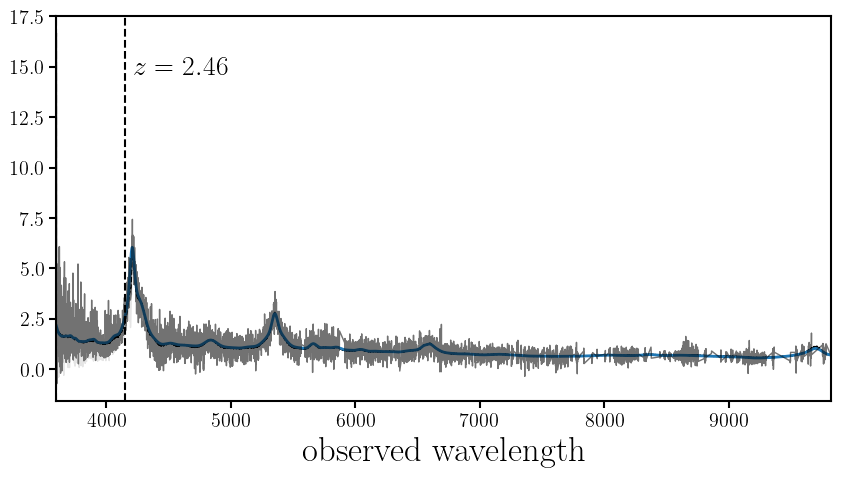

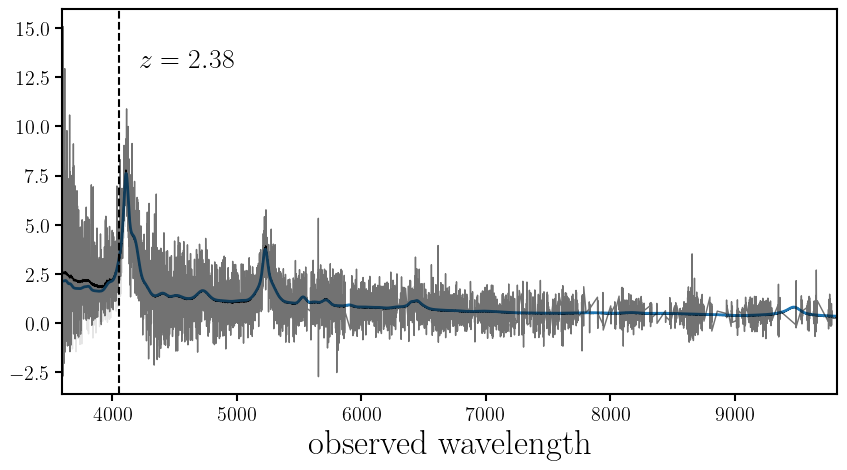

tensor(1.6953e+08)
BATCH 4
24
tensor(1.5682e+08)


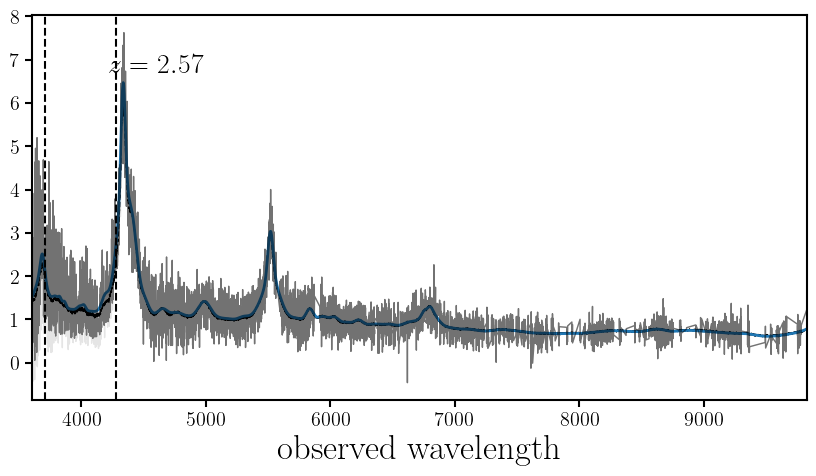

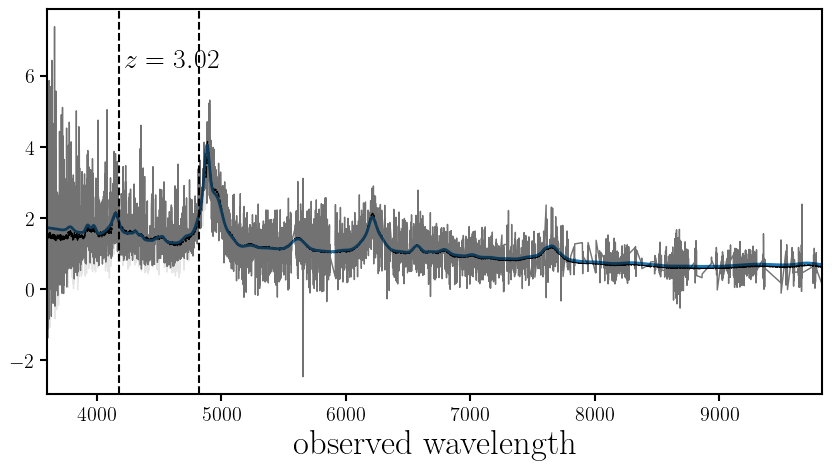

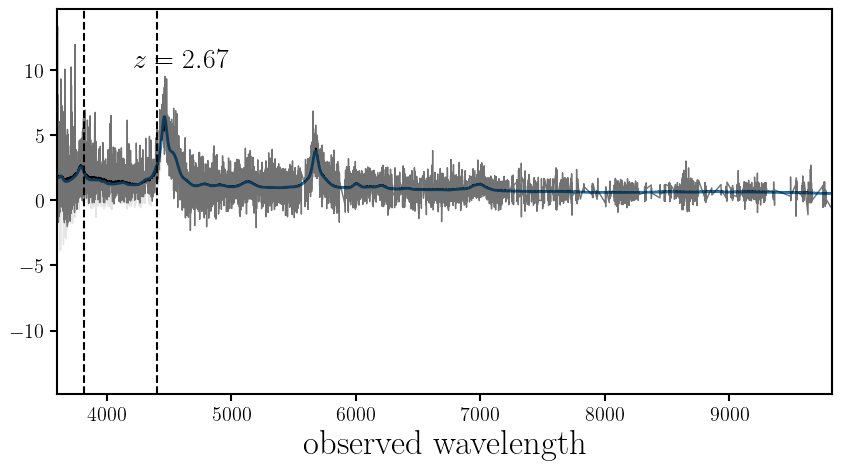

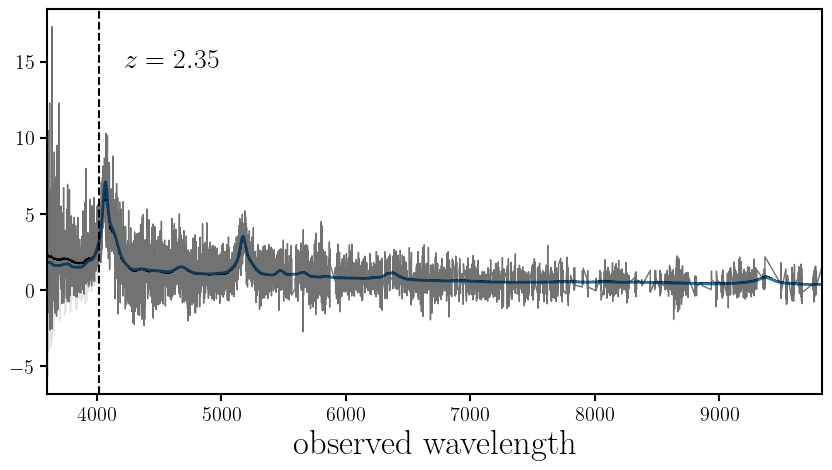

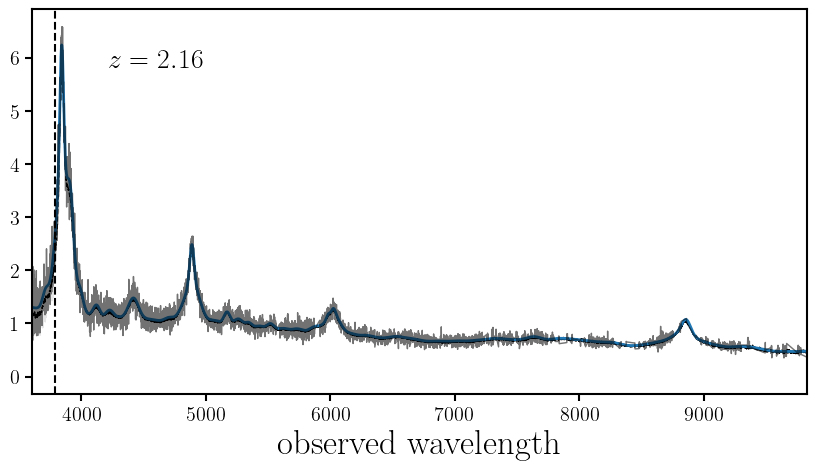

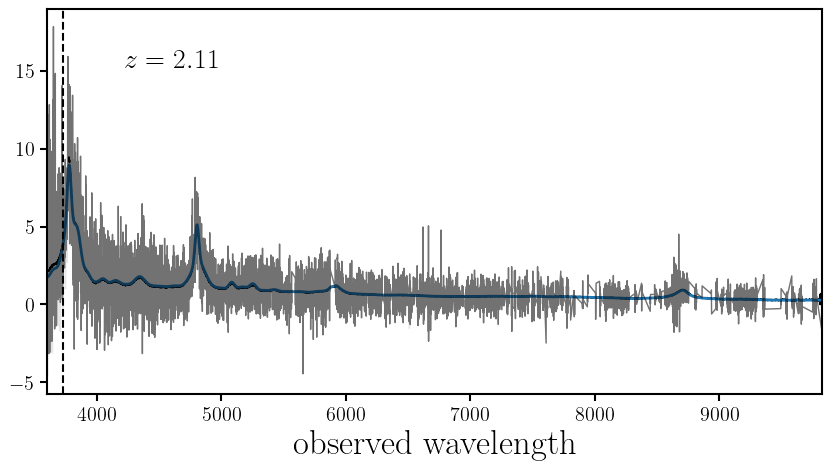

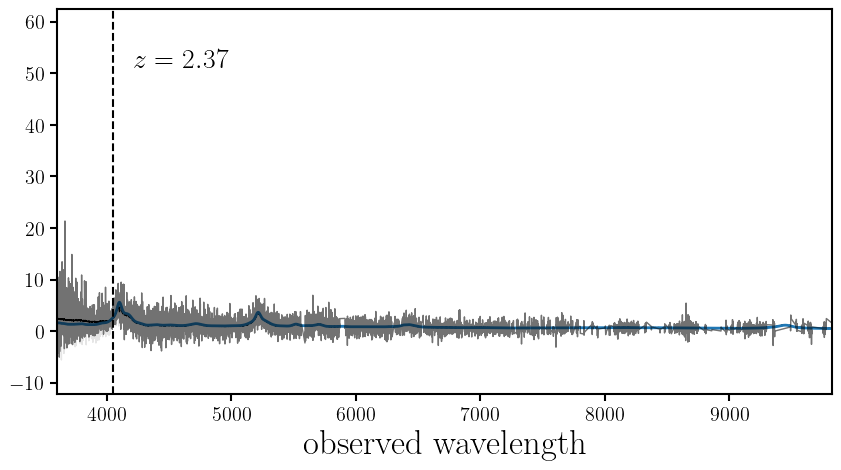

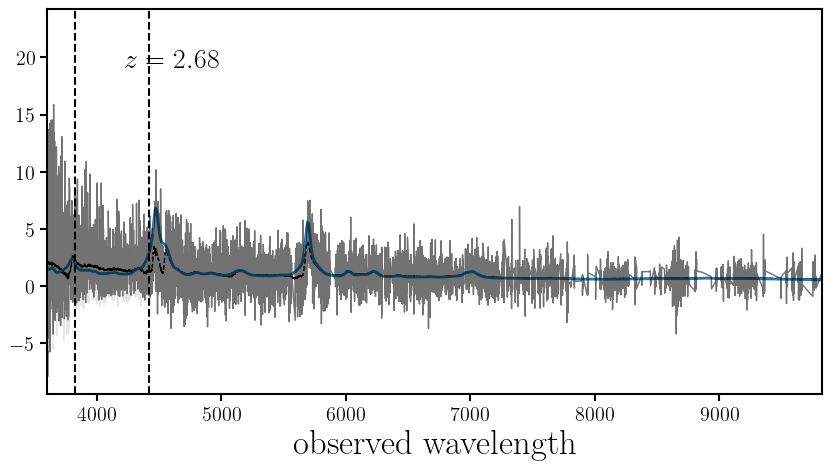

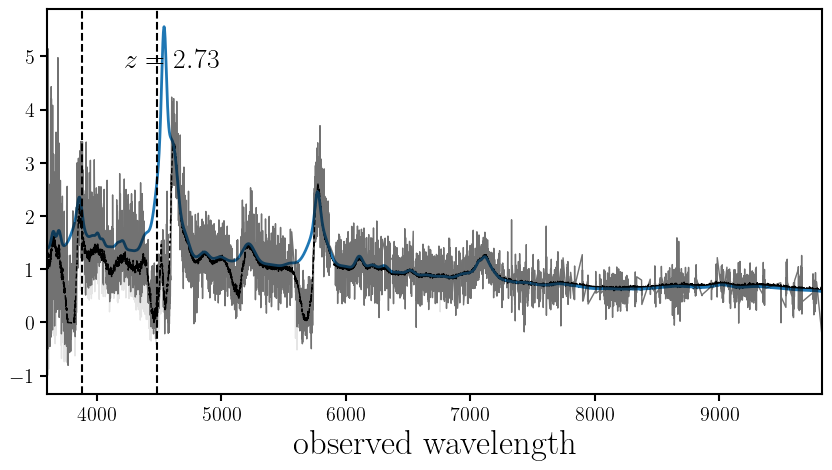

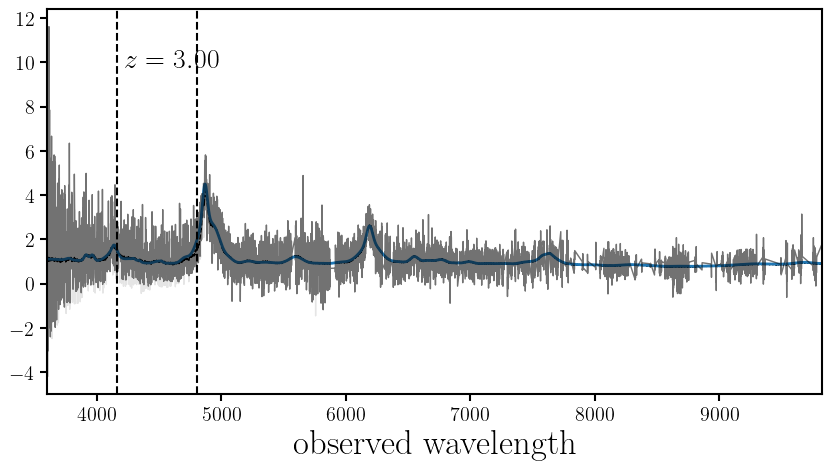

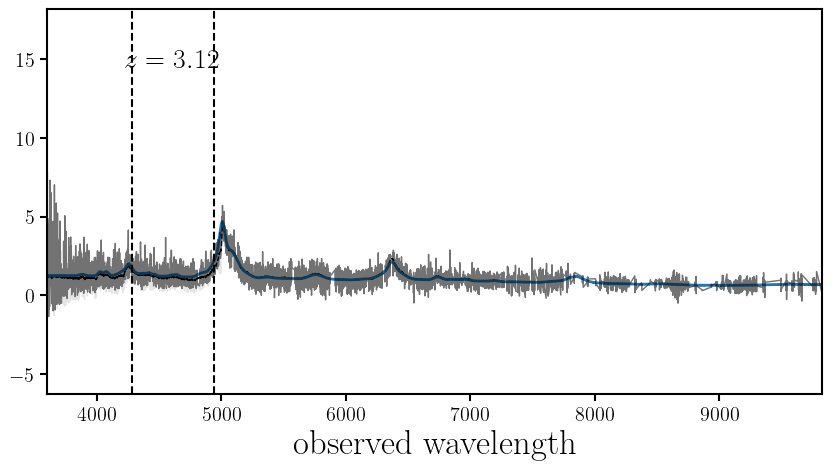

tensor(1.5682e+08)
BATCH 5
23
tensor(2.1954e+08)


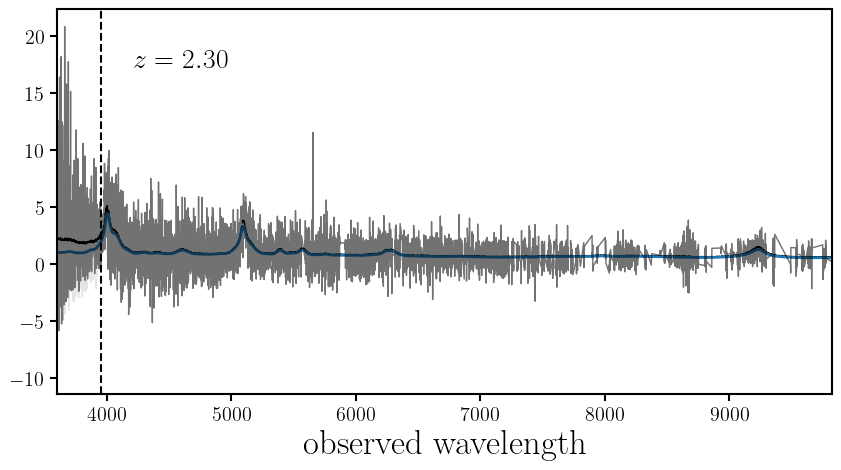

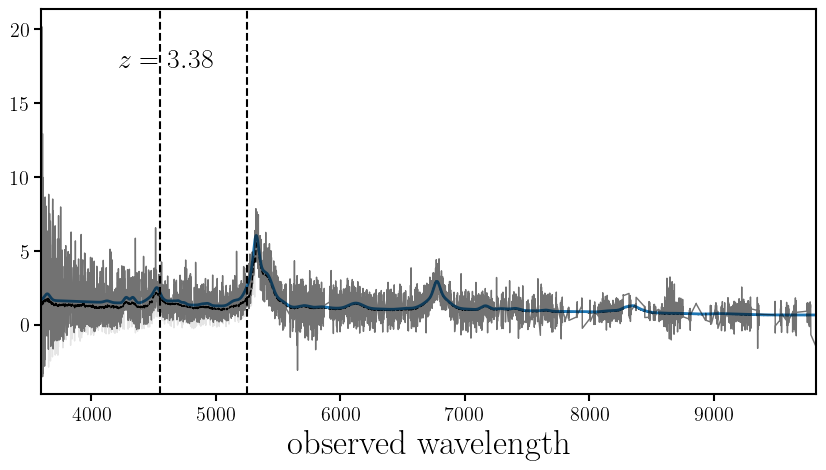

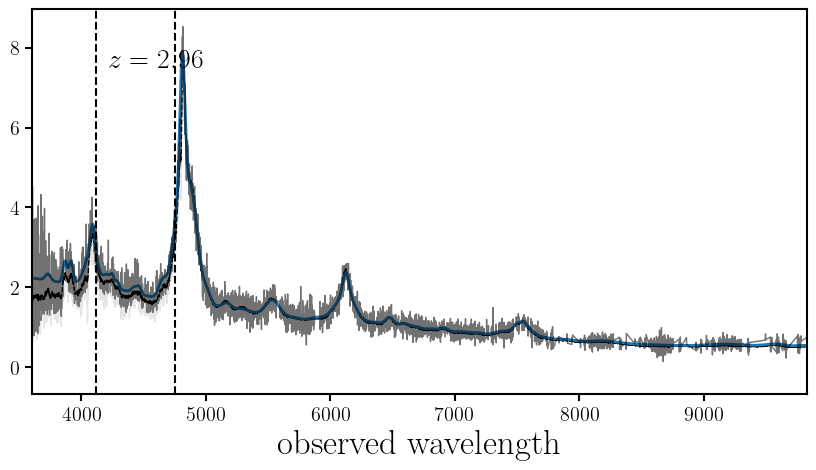

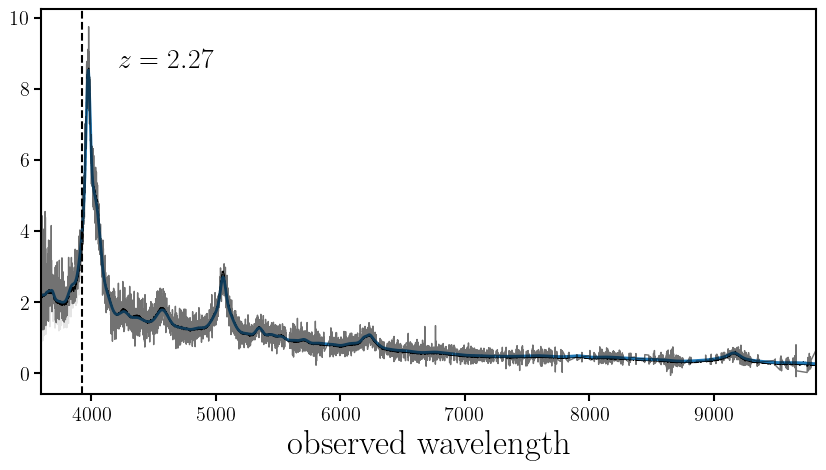

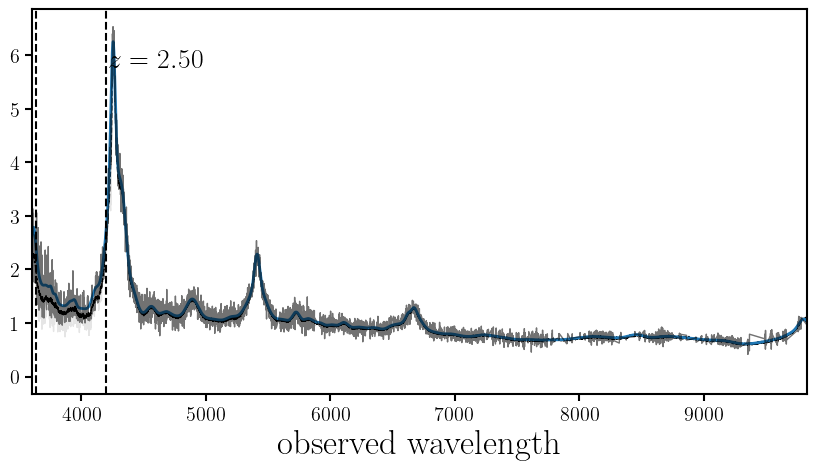

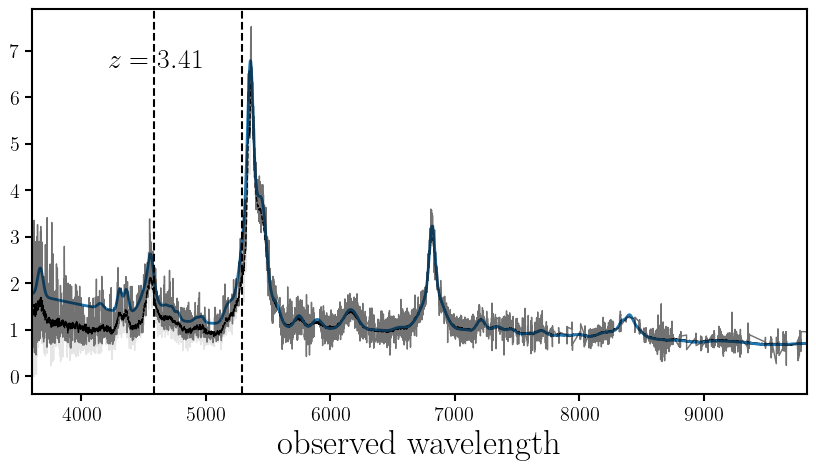

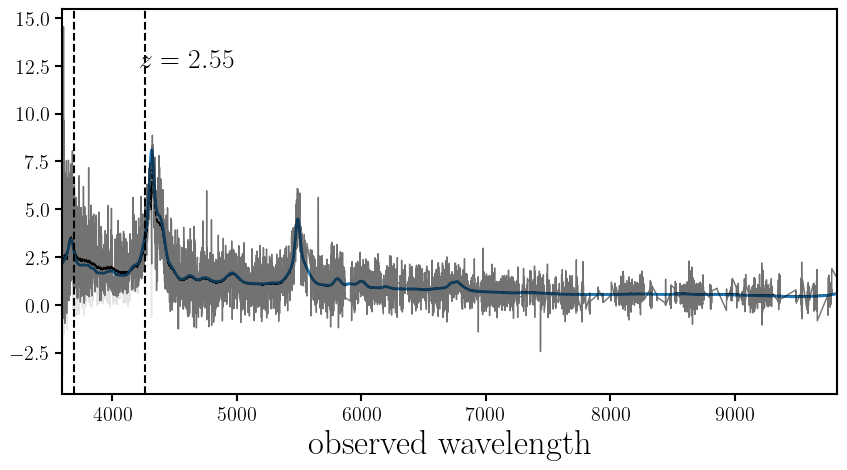

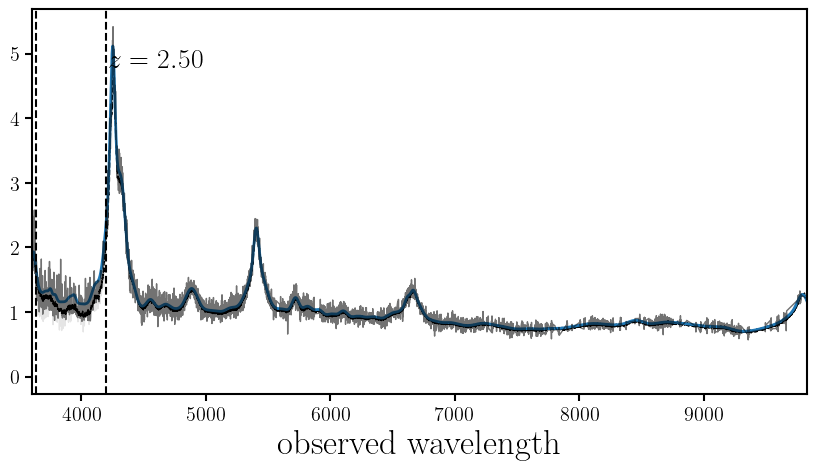

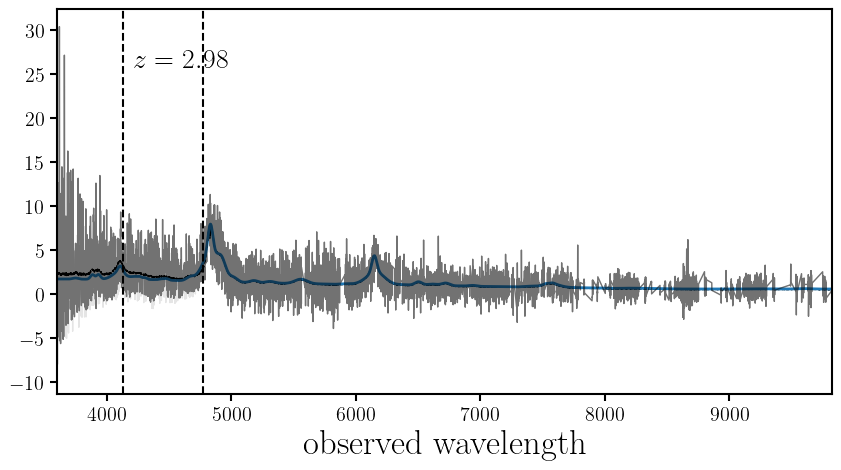

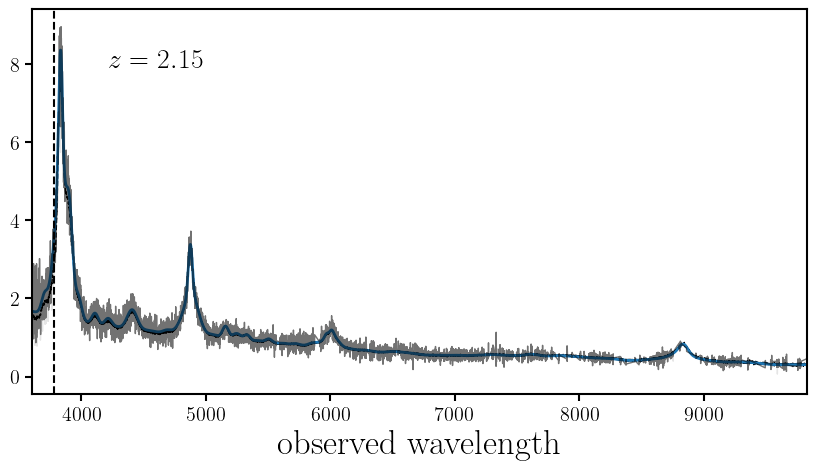

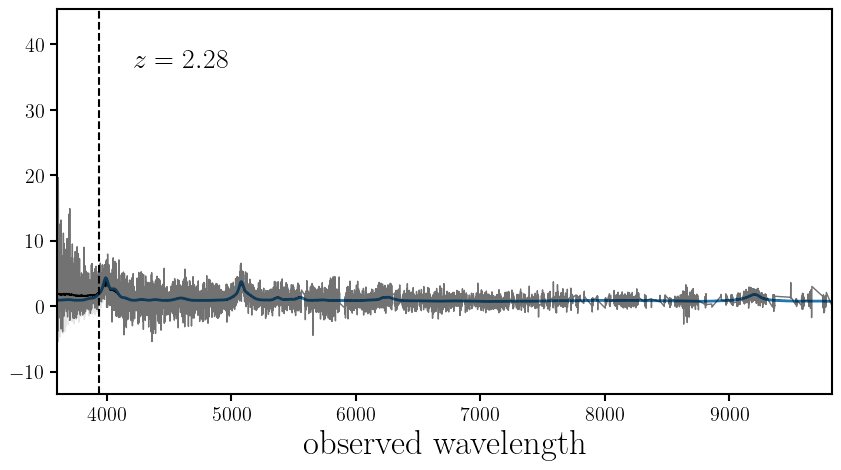

tensor(2.1954e+08)
BATCH 6


In [ ]:
for ibatch in range(100): 
    print('BATCH %i' % ibatch)
    with open('/tigress/chhahn/spender_qso/train/DESIlondon_highz.1sigma.iter%i_%i.pkl' % (niter, ibatch), "rb") as f:
        spec, w, z, target_id, norm, zerr = pickle.load(f)
    
    if ibatch < 50: true_cont = np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz_%i.true_cont.npy' % (ibatch))
    
    with torch.no_grad():
        models[0].eval()
        instruments[0].eval()

        s = models[0].encode(spec)
        spec_rest = models[0].decode(s)
        
    # check for reconstruction accuracy
    is_good = [] 
    for igal in range(spec.shape[0]):
        if z[igal] > 3.499: # quick fix for some wavelength issue
            is_good.append(False)
            continue
        is_good.append(good_recon(np.array(models[0].wave_obs), np.array(spec[igal]), np.array(w[igal]), 
                                       np.array(models[0].wave_rest * (1 + z[igal])), np.array(spec_rest[igal]),   
                                       z[igal].item(), thresholds=[10, 0.1], verbose=False))
    is_good = np.array(is_good)        
    print(np.sum(~is_good))
    if np.sum(is_good) == len(is_good): raise ValueError
    
    # identify clear absorption
    print(w.sum())
    for igal in np.arange(spec.shape[0])[is_good]: 
        is_absorb = find_absorption_aggro(
            np.array(models[0].wave_obs), np.array(spec[igal]), np.array(w[igal]), np.array(z[igal]), 
            np.array(models[0].wave_rest * (1 + z[igal])), np.array(spec_rest[igal]))
        
        if igal % 100 == 0: 
            fig = plt.figure(figsize=(10,5))
            sub = fig.add_subplot(111)
            sub.plot(models[0].wave_obs[w[igal] > 0], spec[igal][w[igal] > 0], c='k', alpha=0.1, lw=1, label='Observed')    
            sub.plot(models[0].wave_rest * (1 + z[igal]), spec_rest[igal], color='k', lw=1, ls='--', label='Reconst.')
        
            if ibatch < 50: 
                sub.plot(np.linspace(3.5e3, 1e4, 3251), true_cont[igal]/norm[igal], c='C0', lw=2, label='True Cont.')
    
            sub.plot(models[0].wave_obs[(w[igal] > 0) & ~is_absorb], spec[igal][(w[igal] > 0) & ~is_absorb], c='k', alpha=0.5, lw=1, label='Observed')    
    
            sub.axvline(1040. * (1+z[igal]), linestyle='--', color='k')
            sub.axvline(1200. * (1+z[igal]), linestyle='--', color='k')

            sub.text(0.1, 0.9, '$z=%.2f$' % z[igal], ha='left', va='top', fontsize=20, transform=sub.transAxes)

            sub.set_xlim(models[0].wave_obs[0], models[0].wave_obs[-1])
    
            sub.set_xlabel("observed wavelength", fontsize=25)
            plt.show()
    print(w.sum())
        
    batch = [spec, w, z, target_id, norm, zerr]
    with open('/tigress/chhahn/spender_qso/train/DESIlondon_highz.1sigma.iter%i_%i.pkl' % (niter+1, ibatch), "wb") as f:
        pickle.dump(batch, f)